Implementation on new data with Bubble

In [100]:
import re
import sys
import csv
import time
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from featurize import tokenize_all
from tqdm import tqdm_notebook
from unidecode import unidecode

from collections import defaultdict
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
from scipy.interpolate import spline

from sklearn import svm, datasets
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectPercentile
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%matplotlib inline

In [2]:
source = 'data/product_nuts_with_usage_and_product_id.csv'

In [3]:
data_pn_usage = []

with open(source) as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in tqdm_notebook(readCSV):
        data_pn_usage.append(eval(row[0]))

In [4]:
id_tokens = tokenize_all(data_pn_usage)

//anaconda/lib/python2.7/site-packages/unidecode/__init__.py:46: RuntimeWarning: Argument <type 'str'> is not an unicode object. Passing an encoded string will likely have unexpected results.
  _warn_if_not_unicode(string)


- Remove doubles
- Include only those nut products if the usage appears in at least 3 products

In [5]:
# removes doubles
known = set()
no_doubles = []

for d in tqdm_notebook(id_tokens):
    tok = ' '.join(d['tokens'])
    if tok in known: 
        continue
    no_doubles.append(d)
    known.add(tok)

In [ ]:
no_doubles[:10]

In [6]:
# makes a dict where each tuple has one usage and all the product_ids linked to it
k = [{x['usage']: x['product_id']} for x in no_doubles]
dd = defaultdict(list)

for d in tqdm_notebook(k): 
    for key, value in d.iteritems():
        dd[key].append(value)

In [7]:
# checks if a usage is linked to at least 3 products
allowed_usage = []
for x in tqdm_notebook(dd.items()):
    if len(set(x[1])) > 2:
        allowed_usage.append(x[0])
        
set_allowed_usage = set(allowed_usage)

complete = []
for x in tqdm_notebook(no_doubles):
    if x['usage'] in set_allowed_usage:
        complete.append(x)

LABELS

In [8]:
labels = [x['product_id'] for x in complete]

In [9]:
K_fold = int(len(set(labels)) / 6)

one = set(list(set(labels))[:K_fold])
two = set(list(set(labels))[K_fold:(K_fold * 2)])
three = set(list(set(labels))[(2 * K_fold):(K_fold * 3)])
four = set(list(set(labels))[(3 * K_fold):(K_fold * 4)])
five = set(list(set(labels))[(4 * K_fold):(K_fold * 5)])
six = set(list(set(labels))[(5 * K_fold):])

labels_6 = []
for label in tqdm_notebook(labels):
    if label in one:
        labels_6.append(1)
    elif label in two:
        labels_6.append(2)
    elif label in three:
        labels_6.append(3)
    elif label in four:
        labels_6.append(4)
    elif label in five:
        labels_6.append(5)
    elif label in six:
        labels_6.append(6)

X

In [10]:
text_per_item_pn_TRAIN = [' '.join(tokens['tokens']) for tokens in complete if tokens['product_id'] not in six]
text_per_item_pn_VALIDATE = [' '.join(tokens['tokens']) for tokens in complete if tokens['product_id'] in six]

In [11]:
vectorizer = CountVectorizer(min_df=1, binary=True)
X_TRAIN = vectorizer.fit_transform(text_per_item_pn_TRAIN)

In [12]:
vocab = vectorizer.vocabulary_
vectorizer = CountVectorizer(min_df=1, vocabulary=vocab)
X_VALIDATE = vectorizer.fit_transform(text_per_item_pn_VALIDATE)

Y

In [13]:
Y_TRAIN = [x['usage'] for x in complete if x['product_id'] not in six]
Y_VALIDATE = [x['usage'] for x in complete if x['product_id'] in six]

In [14]:
labels_TRAIN = []
for x in enumerate(labels_6):
    if x[1] != 6:
        labels_TRAIN.append(x[1])

In [15]:
print 'X: ', X_VALIDATE.shape, 'Y: ', len(Y_VALIDATE)
print 'X: ', X_TRAIN.shape, 'Y: ',len(Y_TRAIN), 'Labels: ', len(labels_TRAIN)

X:  (21021, 26314) Y:  21021
X:  (119050, 26314) Y:  119050 Labels:  119050


** Feature Reduction **

In [37]:
TRAIN = []

percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for precentage in percentages:
    TRAIN.append([precentage, SelectPercentile(percentile=precentage).fit_transform(X_TRAIN, Y_TRAIN)])

In [36]:
TRAIN_SPECIFIC = []

percentages = [71, 72, 73, 74, 75, 76, 77, 78, 79]
for precentage in percentages:
    TRAIN_SPECIFIC.append([precentage, SelectPercentile(percentile=precentage).fit_transform(X_TRAIN, Y_TRAIN)])

Cross_Validation

In [22]:
def compute_scores(X, Y, labels):
    cv = LeaveOneLabelOut(labels_TRAIN)

    clf = LinearSVC(random_state = 2, verbose = 1)
    scores = cross_val_score(clf, X, Y, cv=cv, scoring='accuracy')
    
    return scores

In [84]:
scores = [[train_x[0], compute_scores(train_x[1], Y_TRAIN, labels_TRAIN)] for train_x in TRAIN]

In [38]:
scores_specific = []

for train_x in TRAIN_SPECIFIC 
    scores_specific.append([train_x[0], compute_scores(train_x[1], Y_TRAIN, labels_TRAIN)])
    print 'done'

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]done
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]done
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]done
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]done
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]done
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]done
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]done
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]done
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]done


In [30]:
for score in scores:
    print "Accuracy Linear SVC " + str(score[0]) + ": %0.2f (+/- %0.2f)" % (score[1].mean(), score[1].std() * 2)

Accuracy Linear SVC 10: 0.53 (+/- 0.03)
Accuracy Linear SVC 20: 0.59 (+/- 0.02)
Accuracy Linear SVC 30: 0.61 (+/- 0.03)
Accuracy Linear SVC 40: 0.62 (+/- 0.02)
Accuracy Linear SVC 50: 0.63 (+/- 0.02)
Accuracy Linear SVC 60: 0.63 (+/- 0.02)
Accuracy Linear SVC 70: 0.63 (+/- 0.02)
Accuracy Linear SVC 80: 0.64 (+/- 0.03)
Accuracy Linear SVC 90: 0.64 (+/- 0.03)
Accuracy Linear SVC 100: 0.64 (+/- 0.03)


In [39]:
for score in scores_specific:
    print "Accuracy Linear SVC " + str(score[0]) + ": %0.2f (+/- %0.2f)" % (score[1].mean(), score[1].std() * 2)

Accuracy Linear SVC 71: 0.63 (+/- 0.02)
Accuracy Linear SVC 72: 0.63 (+/- 0.02)
Accuracy Linear SVC 73: 0.63 (+/- 0.02)
Accuracy Linear SVC 74: 0.64 (+/- 0.03)
Accuracy Linear SVC 75: 0.64 (+/- 0.03)
Accuracy Linear SVC 76: 0.64 (+/- 0.03)
Accuracy Linear SVC 77: 0.64 (+/- 0.03)
Accuracy Linear SVC 78: 0.64 (+/- 0.03)
Accuracy Linear SVC 79: 0.64 (+/- 0.03)


In [46]:
scores_all = scores_specific + scores
scores_all = [[score[0], score[1].mean()] for score in scores_all]
scores_all.sort()

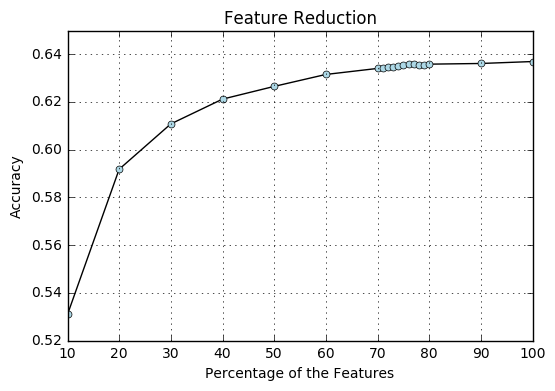

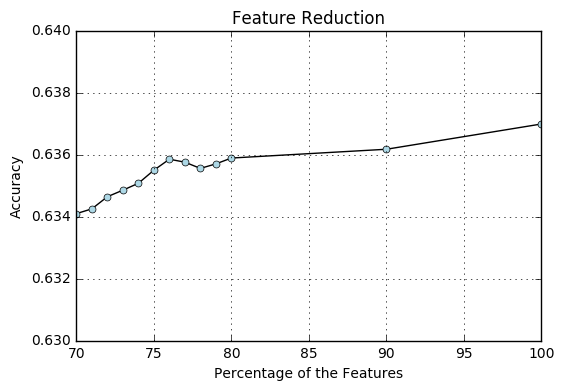

In [152]:
plt.title('Feature Reduction')
plt.xlabel('Percentage of the Features')
plt.ylabel('Accuracy')
plt.ylim([0.52, 0.65])
plt.grid(True)

x = np.array([score[0] for score in scores_all])
y = np.array([score[1] for score in scores_all])

plt.plot(x, y, color='black', marker='o', linestyle='-', markerfacecolor='lightblue', markersize=5)
plt.savefig('feature_reduction.png')
plt.show()


plt.title('Feature Reduction')
plt.xlabel('Percentage of the Features')
plt.ylabel('Accuracy')
plt.ylim([0.63, 0.64])
plt.xlim([70, 100])
plt.grid(True)

x = np.array([score[0] for score in scores_all])
y = np.array([score[1] for score in scores_all])

plt.plot(x, y, color='black', marker='o', linestyle='-', markerfacecolor='lightblue', markersize=5)
plt.savefig('feature_reduction_zoomed_in.png')
plt.show()

** GridSearch **

In [103]:
parameters = {'C':[0.01, 0.1, 1, 10, 100]} 

svr = LinearSVC(random_state = 2, verbose = 1)
cv = LeaveOneLabelOut(labels_TRAIN)
X = TRAIN_SPECIFIC[5][1]

clf = GridSearchCV(svr, parameters, cv=cv, scoring='accuracy')
clf.fit(X, Y_TRAIN)

print("Best parameters set found on development set: \n")
print(clf.best_params_)

grid_scores = []
means = [y[1] for y in clf.grid_scores_]
stds = [np.std(y[2]) for y in clf.grid_scores_]
params = [a[0] for a in clf.grid_scores_]

for mean, std, params in zip(means, stds, params):
    grid_scores.append("%0.2f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
grid_scores

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

//anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:920: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best parameters set found on development set: 

{'C': 0.1}


//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


["0.59 (+/-0.026) for {'C': 0.01}",
 "0.65 (+/-0.029) for {'C': 0.1}",
 "0.64 (+/-0.026) for {'C': 1}",
 "0.59 (+/-0.028) for {'C': 10}",
 "0.53 (+/-0.029) for {'C': 100}"]

In [106]:
grid_scores = ["0.47 (+/-0.032) for {'C': 0.001}"] + grid_scores

In [108]:
co = [(float(grid.split(':')[-1][:-1].strip()),float(grid.split(' ')[0].strip())) for grid in grid_scores]
co.sort()
co

[(0.001, 0.47),
 (0.01, 0.59),
 (0.1, 0.65),
 (1.0, 0.64),
 (10.0, 0.59),
 (100.0, 0.53)]

<function matplotlib.pyplot.show>

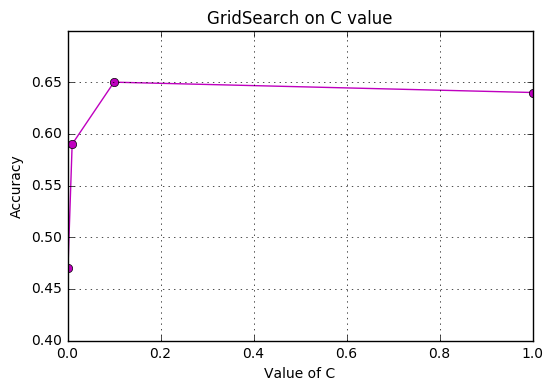

In [153]:
x = [i[0] for i in co]
y = [i[1] for i in co]

plt.plot(x, y, 'm-', marker='o')
plt.grid(True)
plt.ylim([0.4, 0.7])
plt.xlim([0, 1])
plt.title('GridSearch on C value')
plt.xlabel('Value of C')
plt.ylabel('Accuracy')

plt.show

** Validate **

In [131]:
# transform validation set to only contain selected features
selector = SelectPercentile(percentile=76)
selector.fit_transform(X_TRAIN, Y_TRAIN)
X_VAL = selector.transform(X_VALIDATE)

In [134]:
clf = LinearSVC(random_state = 2, verbose = 1, C = 0.1)
clf.fit(TRAIN_SPECIFIC[5][1], Y_TRAIN)
predictions = clf.predict(X_VAL)

[LibLinear]

In [135]:
def classifaction_report_csv(report):
    report_data = []
    lines = report.encode('ascii', 'ignore').split('\n')
    for line in (lines[2:-3] + [lines[-2]]):
        row = {}
        row_data = line.strip().split('  ')
        row_data = [x for x in row_data if x != '']
        row['class'] = row_data[0]
        row['precision'] = row_data[1]
        row['recall'] = row_data[2]
        row['f1_score'] = row_data[3]
        row['support'] = row_data[4]
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    return dataframe

report = classification_report(Y_VALIDATE, predictions)
df = classifaction_report_csv(report)

//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [136]:
print 'macro recall score: ',recall_score(Y_VALIDATE, predictions, average = 'macro')
print 'micro recall score: ',recall_score(Y_VALIDATE, predictions, average = 'micro')

macro recall score:  0.546890774734
micro recall score:  0.739974311403


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


- Reliable Recall Macro Score

In [137]:
report_data = []
lines = report.encode('ascii', 'ignore').split('\n')
for line in (lines[2:-3] + [lines[-2]]):
    row = {}
    row_data = line.strip().split('  ')
    row_data = [x for x in row_data if x != '']
    row['class'] = row_data[0]
    row['precision'] = row_data[1]
    row['recall'] = row_data[2]
    row['f1_score'] = row_data[3]
    row['support'] = row_data[4]
    report_data.append(row)
    
recall = []
for d in report_data:
    if d['support'].strip() != '0':
        recall.append(d['recall'])
        
n_recall = [float(x) for x in recall]
print 'macro recall score: ',sum(n_recall) / len(recall)

macro recall score:  0.600547619048
